In [26]:
import tensorflow as tf
import tensorflow.data as tfd
import pandas as pd
import numpy as np
import os
import json
import datetime
import keras

In [27]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
EPOCHS = 80 * 2
LEARNING_RATE = 1e-3

training = False

#model name is date time
MODEL_NAME = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
MODEL_NAME = 'proc1'
MODEL_NAME += f'_{EPOCHS/2}_{BATCH_SIZE}_{LEARNING_RATE}'

AUTOTUNE = tfd.AUTOTUNE
CALLBACKS = [
    # tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".keras", save_best_only=True)
]

# Paths 
# img_path = '../image_preprocessing/Out'
img_path = '../dataset/img'
transcriptions = '../dataset/transcriptions.json'

# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

In [28]:
# Load the json files and transform into dataframes

def json_to_csv(json_path):
    # Load the JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Convert the data to a pandas DataFrame
    return pd.DataFrame(data)
 
all_transcriptions = json_to_csv(transcriptions)   

In [29]:
all_transcriptions.head()

,decade_id,height,img,nameset,text,width
0,0,130,002_02_00.jpg,train,Lettera di Lod. Antonio,1120
1,0,147,002_02_01.jpg,train,di Giacomo Bianchi,986
2,1,112,002_04_00.jpg,train,Arona 30. 9bre. 94.,657
3,1,82,002_04_01.jpg,train,Sorella amatissima,544
4,1,93,002_04_02.jpg,train,Veramente il vostro caso è degno di compassion...,1654


In [30]:
def filter_no_longer_than_50(df):
    return df[df['text'].apply(lambda x: len(x) <= 50)]

def add_file_path(df):
    df['file_name'] = df['img'].apply(lambda x: img_path + '/' + x)
    return df

def drop_unnecessary_columns(df):
    return df.drop(columns=['decade_id', 'nameset', 'height', 'width'])

def transform_pipeline(df):
    return filter_no_longer_than_50(add_file_path(drop_unnecessary_columns(df)))

all_transcriptions = transform_pipeline(all_transcriptions)

def check_img_exists(df):
    #drop imgs that do not exist
    return df[df['file_name'].apply(lambda x: os.path.exists(x))]

all_transcriptions = check_img_exists(all_transcriptions)

length = len(all_transcriptions)
train_csv = all_transcriptions[:int(length * 0.8)]
test_csv = all_transcriptions[int(length * 0.8):]

length = len(train_csv)
valid_csv = train_csv[int(length * 0.8):]
train_csv = train_csv[:int(length*0.8)]

print(len(train_csv['img']))
print(len(valid_csv['img']))
print(len(test_csv['img']))

TRAIN_SIZE = len(train_csv['img'])
VALID_SIZE = len(valid_csv['img'])
TEST_SIZE = len(test_csv['img'])


15275
3819
4774


In [31]:
# print the first 16 in test_csv
for i in range(16):
    print(test_csv['img'].iloc[i] + ' -' + test_csv['text'].iloc[i])

037_1456_05.jpg -ricevuto il Libro venuto di Brescia. Ve-
037_1456_06.jpg -ram.e mi pare d'aver fatto qualche guadagno
037_1456_07.jpg -in quest'aria: pure seguito la debolezza
037_1456_08.jpg -nelle braccia e mani; e vo pensando al ri-
037_1456_09.jpg -torno. Potevate ben dirmi d'aver fatta
037_1456_10.jpg -richiesta pel pagam.o della Polizza, e che
037_1456_11.jpg -non s'è peranche ricevuta risposta. Ca-
037_1456_12.jpg -ram.e salutate tutti di casa. Mi ricordo
037_1456_13.jpg -Vro Aff.mo Zio e Ser.r
037_1456_14.jpg -Lod.o Ant.o Muratori
037_1459_00.jpg -Al Riv:mo Sig.r Mio e Pron Col.mo
037_1459_01.jpg -Il Sig.r Dre Gian. Franc.o Soli
037_1459_02.jpg -Proposto della
037_1459_03.jpg -Pomposa.
037_1459_04.jpg -Modena.
037_1460_00.jpg -Nip.e Car.mo


In [32]:
# get the train labels 
train_labels = [str(word) for word in train_csv["text"].to_numpy()]
val_labels = [str(word) for word in valid_csv["text"].to_numpy()]
test_labels = [str(word) for word in test_csv["text"].to_numpy()]

# extract all the unique characters
unique_characters_train = set(char for word in train_labels for char in word)
unique_characters_test = set(char for word in test_labels for char in word)
unique_characters_val = set(char for word in val_labels for char in word)

# get the unique characters
unique_characters = unique_characters_train.union(unique_characters_test).union(unique_characters_val)
print(unique_characters)

if not training:
    unique_characters = sorted(unique_characters)
    print(unique_characters)

# save to json
with open('unique_characters.json', 'w') as f:
    json.dump(unique_characters, f, indent=4)



# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

MAX_LABEL_LENGTH = max(map(len, train_labels))

{'h', 'l', '&', 'C', '8', 'ì', '|', ' ', '(', '.', '9', '°', 'Q', '7', '3', 'u', 'w', "'", 'D', 'J', '=', 'H', 'É', '%', 'a', 'V', 'v', '–', 'r', '/', 'M', 'X', '5', 'n', 'ò', 'x', 'I', 'j', 'ù', '#', 'K', 'i', 'A', 'È', '!', 'è', 'R', ')', 'U', ';', '2', 'é', '0', 'y', '4', 'f', '·', '1', 'z', 'à', '6', 'S', 'p', ',', 'Z', '?', 'g', 'P', 'd', 'T', 'b', ':', 'o', '-', 'm', 'e', 'B', 'O', 'F', 'N', 't', 's', 'c', 'E', 'G', 'L', '+', 'q'}
[' ', '!', '#', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '°', '·', 'È', 'É', 'à', 'è', 'é', 'ì', 'ò', 'ù', '–']


In [33]:
print("Number of unique characters: ", n_classes)
print("Max label length: ", MAX_LABEL_LENGTH)

Number of unique characters:  88
Max label length:  50


In [34]:
from keras.src.layers import StringLookup

# Char to Num
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

print(char_to_num.get_vocabulary())

['[UNK]', ' ', '!', '#', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '°', '·', 'È', 'É', 'à', 'è', 'é', 'ì', 'ò', 'ù', '–']


In [35]:
unk = char_to_num('[UNK]')

In [36]:
def load_image(image_path):
    """
    This function gets the image path and 
    reads the image using TensorFlow, Then the image will be decoded and 
    will be converted to float data type. next resize and transpose will be applied to it.
    In the final step the image will be converted to a Numpy Array using tf.cast
    """
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose 
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [37]:
def encode_single_sample(image_path, label:str):
    if image_path is None:
        print("Found None in image_path")
        raise ValueError("Image path is None")
    if label is None:
        print("Found None in label")
        raise ValueError("Label is None")
    
    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Create a list to hold the valid vectors
    oov_found = tf.constant(0)
    for vec in vecs:
        if vec == char_to_num('[UNK]'):
            print(f"Found OOV token in vec: {vec}")
            oov_found = tf.constant(1)
            break
            

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs, 'oov_found':oov_found}

In [38]:
train_images = train_csv['file_name'].to_numpy()
test_images = test_csv['file_name'].to_numpy()
valid_images = valid_csv['file_name'].to_numpy()

In [39]:
def lay_dataset(images, labels, shuffle = True, batch_size = BATCH_SIZE):
    if shuffle:
        ds = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((images, labels)).map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    
    # Filter out the samples with OOV tokens
    ds = ds.filter(lambda sample: tf.equal(sample['oov_found'], 0))
    
    return ds.batch(batch_size).prefetch(AUTOTUNE)

In [40]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [41]:
train_ds = lay_dataset(train_images, train_labels)
valid_ds = lay_dataset(valid_images, val_labels, shuffle=False)
test_ds = lay_dataset(test_images, test_labels, shuffle=False)

Found OOV token in vec: Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=int64)
Found OOV token in vec: Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=int64)
Found OOV token in vec: Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=int64)


In [42]:
def make_prediction(model, image, decode_pred, load_image = load_image):
    """
    This function takes the model, image and decode_pred function as input and 
    returns the prediction of the model.
    """
    # Load the image
    image = load_image(image)
    # Make prediction
    pred = model.predict(tf.expand_dims(image, axis=0))
    # Decode the prediction
    pred = decode_pred(pred)[0]
    
    return pred

In [43]:
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls


def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        if index >= 16:
            break
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

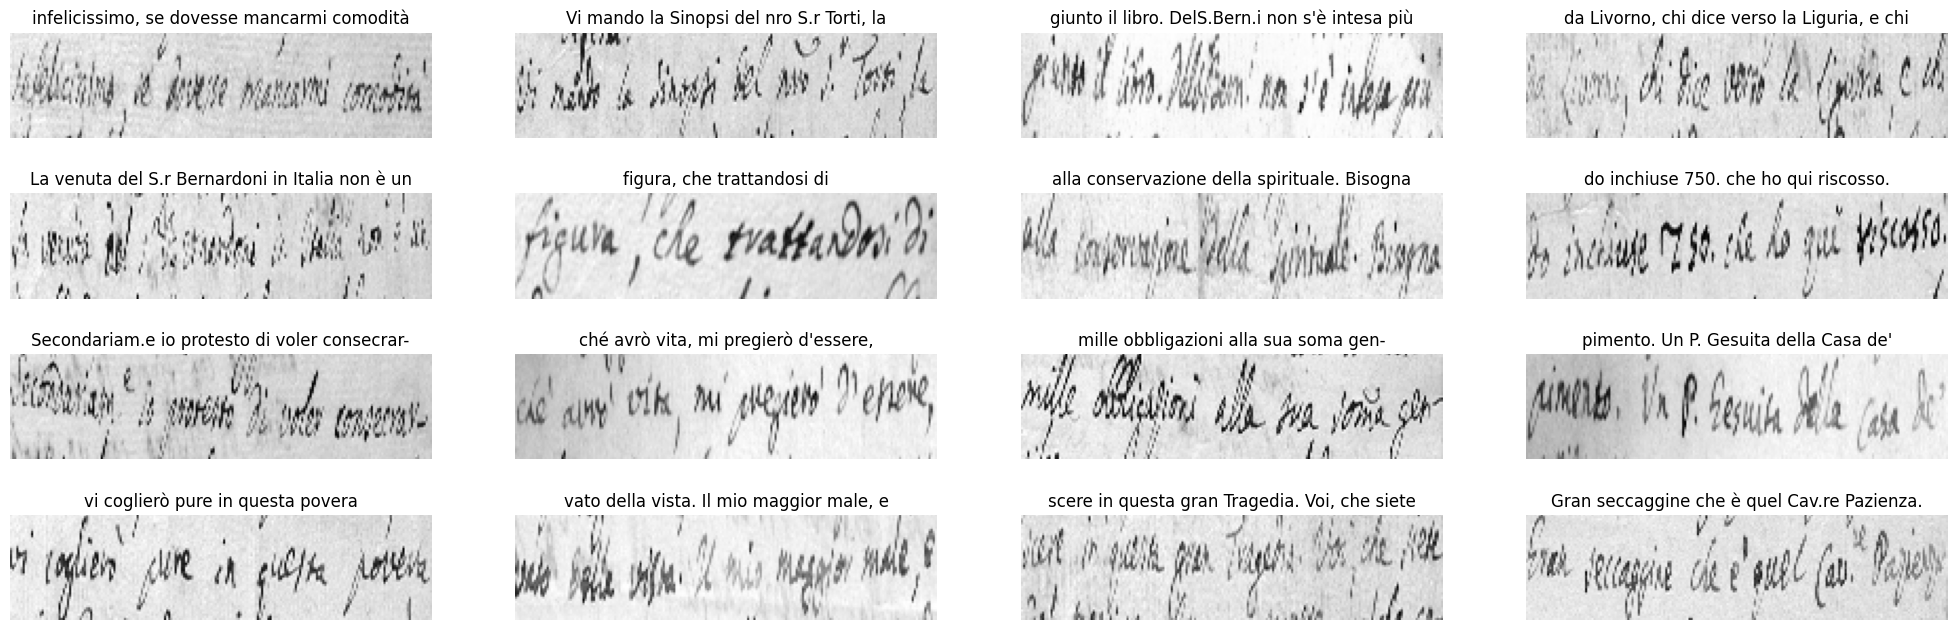

In [44]:
show_images(data=train_ds, GRID=[4,4], FIGSIZE=(25, 8))

In [45]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model 

In [46]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # define the loss function 
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length 
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        # calculate the loss
        loss = self.loss_function(y_true, y_hat, input_len, label_len) 

        self.add_loss(loss)

        return y_hat
    
    def get_config(self):
        return super().get_config()
    

In [47]:
# Input Layer
input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")

### Convolutional layers
# layer 1 
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
# layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# layer 3
conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)

### Encoding 
reshape = Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*32), name="reshape_layer")(max_pool_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

# Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Final Output layer
output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)

# Add the CTC loss 
ctc_loss_layer = CTCLayer()(input_labels, output) 

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])

In [48]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 200, 50,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 200, 50,   │     18,464 │ conv_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 100, 25,   │          0 │ conv_2[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 100, 25,   │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 100, 25,   │     18,464 │ conv_3[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 50, 12,    │          0 │ conv_4[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_layer       │ (None, 50, 384)   │          0 │ max_pooling2d_3[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enconding_dense     │ (None, 50, 64)    │     24,640 │ reshape_layer[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enconding_dense_2   │ (None, 50, 64)    │      4,160 │ enconding_dense[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 64)    │          0 │ enconding_dense_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 50, 256)   │    197,632 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 50, 128)   │    164,352 │ bidirectional_ls… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 50, 90)    │     11,610 │ bidirectional_ls… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer_1         │ (None, 50, 90)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ output_dense[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,458 (1.75 MB)

 Trainable params: 458,458 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
optimizer= keras.optimizers.Adam()
print(optimizer.learning_rate.numpy())

model.compile(optimizer=optimizer)

0.001


In [50]:
if training:
    def check_none_values(dataset):
        for batch in dataset:
            for data in batch:
                if data is None:
                    return True
        return False
    
    # Check train_ds
    if check_none_values(train_ds):
        print("None values found in train_ds")
    
    # Check valid_ds
    if check_none_values(valid_ds):
        print("None values found in valid_ds")
    
    # If no None values are found, proceed with fitting the model
    if not check_none_values(train_ds) and not check_none_values(valid_ds):
        history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=CALLBACKS, steps_per_epoch = int(TRAIN_SIZE/BATCH_SIZE), validation_steps = VALID_SIZE//BATCH_SIZE)
    else:
        print("Datasets contain None values. Please fix the data before training the model.")
        
    # Save the model
    model.save(MODEL_NAME + ".keras")

In [51]:
import math


def plot_training(history):
        plt.figure(figsize=(15,5))
        
        plt.subplot(1,2,1)
        loss = [x for x in history.history['loss'] if str(x) != 'inf']
        val_loss = [x for x in history.history['val_loss'] if str(x) != 'inf']
        plt.plot(loss, label="Training loss")
        plt.plot(val_loss, label="Validation Loss")
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.show()
        
if training:        
    plot_training(history)
    

In [52]:
#Evaluate the model using cer and wer
from Metrics import Calculate_CER, Calculate_WER

def evaluate_model(model, dataset, decode_pred):
    """
    This function evaluates the model using the Character Error Rate and Word Error Rate
    """
    # Initialize the lists to hold the CER and WER values
    CER = []
    WER = []
    
    # Initialize the lists to hold the true and predicted texts
    true_texts = []
    pred_texts = []
    
    # Iterate over the dataset
    for batch in dataset:
        # Get the images and labels
        images, labels = batch['image'], batch['label']
        
        # Make predictions
        pred = model.predict(images)
        
        # Decode the predictions
        pred_texts += decode_pred(pred)
        
        # Get the true texts
        true_texts += [tf.strings.reduce_join(num_to_char(label)).numpy().decode('UTF-8').replace('[UNK]', ' ').strip() for label in labels]
        
        
        
    # Calculate the CER and WER
    CER = Calculate_CER(true_texts, pred_texts)
    WER = Calculate_WER(true_texts, pred_texts)
    
    
    return CER, WER, true_texts



In [53]:
def decoder_prediction(pred_label):
    """
    This function has the job to decode the prediction that the model had.
    The model predicts each character and then this function makes it readable. 
    """
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts

In [54]:
def create_cuban(folder):
    img_path = '../dataset/' + folder
    transcriptions = f'../dataset/{folder}/Transcription.json'
    
    #get all the transcriptions
    all_transcriptions = json_to_csv(transcriptions)
    
    test_labels = [str(word) for word in all_transcriptions["text"].to_numpy()]
    
    images = all_transcriptions['img'].to_numpy()
    images = [img_path + '/' + str(img) for img in images]
    
    return images, test_labels


In [55]:
# reconstructed_model = keras.models.load_model(MODEL_NAME + '.keras', custom_objects={'CTCLayer': CTCLayer})
if not training:
    model = load_model(MODEL_NAME + ".keras", custom_objects={'CTCLayer': CTCLayer})
    model.summary()
    pred_m_it = Model(input_images, output)
    pred_m_it.set_weights(model.get_weights())
    CER, WER, _ = evaluate_model(pred_m_it, test_ds, decoder_prediction)
    print(CER,WER)

    

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 200, 50,   │        640 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 200, 50,   │     18,464 │ conv_1[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 25,   │          0 │ conv_2[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 100, 25,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 100, 25,   │     18,464 │ conv_3[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 12,    │          0 │ conv_4[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_layer       │ (None, 50, 384)   │          0 │ max_pooling2d_1[… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enconding_dense     │ (None, 50, 64)    │     24,640 │ reshape_layer[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enconding_dense_2   │ (None, 50, 64)    │      4,160 │ enconding_dense[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ enconding_dense_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm… │ (None, 50, 128)   │    164,352 │ bidirectional_ls… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_dense        │ (None, 50, 90)    │     11,610 │ bidirectional_ls… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_layer           │ (None, 50, 90)    │          0 │ label[0][0],      │
│ (CTCLayer)          │                   │            │ output_dense[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,375,376 (5.25 MB)

 Trainable params: 458,458 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 916,918 (3.50 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━

In [56]:
folder1 = 'A'
folder2 = 'B'
folder3 = 'C'
folder4 = 'D'


cub_i, cub_l = create_cuban(folder1)
cub_i1, cub_l1 = create_cuban(folder2)
cub_i2, cub_l2 = create_cuban(folder3)
cub_i3, cub_l3 = create_cuban(folder4)



cub_i = cub_i + cub_i1 + cub_i2 + cub_i3
cub_l = cub_l + cub_l1 + cub_l2 + cub_l3


In [57]:
# remove anything over 50 char
for i in reversed(range(len(cub_l))):
    if len(cub_l[i]) > 50:
        cub_l.pop(i)
        cub_i.pop(i)


        

In [58]:
cuban_train_images = cub_i[:int(len(cub_i) * 0.8)]
cuban_train_labels = cub_l[:int(len(cub_i) * 0.8)]

cuban_test_images = cub_i[int(len(cub_i) * 0.8):]
cuban_test_labels = cub_l[int(len(cub_i) * 0.8):]

print(f'Train: {len(cuban_train_images)} \n '
      f'Test: {len(cuban_test_images)}')

for i in cuban_train_images:
    print(i)

cub_batches = 1
cub_epochs = 30
# 30 - 0.28
# 35 - 0.30


cuban_ds = lay_dataset(cuban_train_images  , cuban_train_labels  , batch_size=cub_batches)
# valid_ds = lay_dataset(cuban_val_images, cuban_val_labels, shuffle=False, batch_size=cub_batches)




Train: 221 
 Test: 56
../dataset/A/Seg_A0.jpg
../dataset/A/Seg_A1.jpg
../dataset/A/Seg_A2.jpg
../dataset/A/Seg_A3.jpg
../dataset/A/Seg_A4.jpg
../dataset/A/Seg_A5.jpg
../dataset/A/Seg_A6.jpg
../dataset/A/Seg_A7.jpg
../dataset/A/Seg_A8.jpg
../dataset/A/Seg_A9.jpg
../dataset/A/Seg_A10.jpg
../dataset/A/Seg_A11.jpg
../dataset/A/Seg_A12.jpg
../dataset/A/Seg_A13.jpg
../dataset/A/Seg_A14.jpg
../dataset/A/Seg_A15.jpg
../dataset/A/Seg_A16.jpg
../dataset/A/1.jpg
../dataset/A/2.jpg
../dataset/A/3.jpg
../dataset/A/4.jpg
../dataset/A/5.jpg
../dataset/A/6.jpg
../dataset/A/segm_1.jpg_0.jpg
../dataset/A/segm_1.jpg_1.jpg
../dataset/A/segm_1.jpg_2.jpg
../dataset/A/segm_1.jpg_3.jpg
../dataset/A/segm_1.jpg_4.jpg
../dataset/A/segm_1.jpg_5.jpg
../dataset/A/segm_1.jpg_6.jpg
../dataset/A/segm_1.jpg_7.jpg
../dataset/A/segm_1.jpg_8.jpg
../dataset/A/segm_1.jpg_9.jpg
../dataset/A/segm_1.jpg_10.jpg
../dataset/A/segm_2_0.jpg
../dataset/A/segm_2_1.jpg
../dataset/A/segm_2_3.jpg
../dataset/A/segm_2_4.jpg
../dataset/A/s

In [72]:
#fit the cuban data in the model 
# optimizer = keras.optimizers.Adam(0.01)
# model.compile(optimizer)
history = model.fit(cuban_ds, steps_per_epoch=len(cuban_train_images)//cub_batches, epochs=cub_epochs)


Epoch 1/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: inf
Epoch 2/30
  5/221 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 47.8098

C:\Users\karen\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: inf
Epoch 3/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: inf
Epoch 4/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: inf
Epoch 5/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: inf
Epoch 6/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: inf
Epoch 7/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: inf
Epoch 8/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: inf
Epoch 9/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: inf
Epoch 10/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: inf
Epoch 11/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: inf
Epoch 12/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: inf
Epoch 13/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: inf
Epoch 14/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: inf
Epoch 15/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: inf
Epoch 16/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: inf
Epoch 17/30
221/221 ━━━━━━━━━

In [73]:
prediction_model = Model(input_images, output)

if not training:
    prediction_model.set_weights(model.get_weights())
    prediction_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 200, 50, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 200, 50, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 100, 25, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 100, 25, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 100, 25, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (Reshape)         │ (None, 50, 384)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enconding_dense (Dense)         │ (None, 50, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enconding_dense_2 (Dense)       │ (None, 50, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 50, 90)         │        11,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,458 (1.75 MB)

 Trainable params: 458,458 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
#assert the weights are the same
if not training:
    for layer in prediction_model.layers:
        if layer.get_weights():
            #if has more than one dimension
            if len(layer.get_weights()) > 1:
                for i in range(len(layer.get_weights())):
                    assert np.allclose(layer.get_weights()[i], model.get_layer(layer.name).get_weights()[i])
            else:
                assert np.allclose(layer.get_weights(), model.get_layer(layer.name).get_weights())

In [62]:
# show_images(data=test_ds, model=prediction_model, decode_pred=decoder_prediction, cmap='binary')

In [63]:
# CER, WER = evaluate_model(prediction_model, test_ds, decoder_prediction)
# CER, WER

In [75]:
test_ds = lay_dataset(cuban_test_images, cuban_test_labels , shuffle=False, batch_size=cub_batches)
CER, WER, true_texts = evaluate_model(prediction_model, test_ds, decoder_prediction)

print(f"CER: {CER} \nWER: {WER}")


# cada vez q se entrena se obtiene resultados diferentes, quedarse con el mejor

Found OOV token in vec: Tensor("while/TensorArrayV2Read/TensorListGetItem:0", shape=(), dtype=int64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

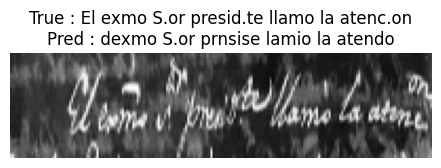

In [76]:
show_images(data=test_ds, model=prediction_model, decode_pred=decoder_prediction, cmap='binary')

In [77]:
#print the predicted 
def print_predicted(model, image, decode_pred):
    """
    This function takes the model, image and decode_pred function as input and 
    returns the prediction of the model.
    """
    # Load the image
    image = load_image(image)
    # Make prediction
    pred = model.predict(tf.expand_dims(image, axis=0))
    # Decode the prediction
    pred = decode_pred(pred)[0]
    
    return pred

ans = []
for image in cuban_test_images:
    pred = print_predicted(prediction_model, image, decoder_prediction)
    ans.append(pred)
    
actual = cuban_test_labels

for p,a in zip(ans, actual):
    print(f"Predicted: {p} \nActual: {a}\n\n")
    


    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [67]:
#save to json

def save_to_json(actual, pred, name='results.json'):
    post = {}
    ind = 0
    for ac, pr in zip(actual, pred):
        data = {}
        data['actual'] = ac
        data['predicted'] = pr
        post[ind] = data
        ind +=1
        
    with open(name, 'w') as f:
        json.dump(post, f, indent=4)
        
save_to_json(actual, ans)
        
print(char_to_num.get_vocabulary())
        

['[UNK]', ' ', '!', '#', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '°', '·', 'È', 'É', 'à', 'è', 'é', 'ì', 'ò', 'ù', '–']


In [68]:
#save model
model.save('cuban_docs.keras')

In [78]:
import pytesseract
from PIL import Image
import os, sys

# tesseract path
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
# tesseract tessdata path
os.environ['TESSDATA_PREFIX'] = r'C:/Program Files/Tesseract-OCR/tessdata'


In [79]:
tesseract_preds_old = []
tesseract_preds = []
for image in cuban_test_images:
    img = Image.open(image)
    text = pytesseract.image_to_string(img, lang='spa_old')
    tesseract_preds_old.append(text)
    text = pytesseract.image_to_string(img, lang='spa')
    tesseract_preds.append(text)
    

print(tesseract_preds)

['\' N y e% d P\nQfº"?1 .,f7\' XM¡M%”Z” á _”"¿__\n\n—\nl a un x\n', '” RdA a la el E ub eni a nt d Pr, Pr e\n', '', '>y tºntianidº vinig uñe dte > fmtbiº, 9E\nWv xe aa¿¿bf t? 9£J ea\n', 'falr ; Pecieniº pniey Bigne 98 Otestan 726\n', '', '', '', 'M &eyº entenites? aterca, 90 exél piditalº ; p em\n', '”tratº Derban 3Tem0 elr (e> Etºbiren d, de Lay P3 —\n', '', '', '', '£430 a £0£bm… 9M&MVSU n$::rw /E Atº%X —\n\nla ás y\n', "*3'º7v)bºw ¿v(/'¿¿n¿zaíuÁ/¡óumu tin Ofa ea &&\n", '', '"¿7\'“ MÚQ% Bºr bn 22\n', 'F t : º\nÚta d E Qe © ben\ny LCº —\n', '', 'ientererantrs Varcº: S AB Niatrzº , y) 31 ME PPZ_\n', 'E lepensn: lalº Inmtunciade 30 B%y\n', 'laca (lecia ) PÚ RZ del Casscits p 92y M\n', '', 'y 1 a J * |\n¿"\'Á fac/Z_*_7-?/rgv£o ee \'Bn£erctºr)? ;D &Ertc t ?z,,¿_¿l\n', '', '', "'(5¿'9-“Iro 9t—o12¿íx/..¿v' < g,*\n", 'e A\n', '', 'D Efºnrnelº %e las Dúgrcices y\n© infºnrnalº % das Digictaces prºmidratraº º l\n', "4\n\n¿$b…)— ff¿m%w cºnsiDena en' (4\n", '', '', "Mn) 9c//b?'/u 9¿4…W1 ue P aans

In [80]:
# delete all '\n' and '\x0c' characters
tesseract_preds = [text.replace('\n', '').replace('\x0c', '') for text in tesseract_preds]
tesseract_preds_old = [text.replace('\n', '').replace('\x0c', '') for text in tesseract_preds_old]
# replace all \u weird characters
tesseract_preds = [text.encode('ascii', 'ignore').decode() for text in tesseract_preds]
tesseract_preds_old = [text.encode('ascii', 'ignore').decode() for text in tesseract_preds_old]
print(tesseract_preds)



save_to_json(actual, tesseract_preds, 'tesseract_results.json')
save_to_json(actual, tesseract_preds_old, 'tesseract_results_old.json')

CER = Calculate_CER(cuban_test_labels, tesseract_preds)
CERold = Calculate_CER(cuban_test_labels, tesseract_preds_old)

WER = Calculate_WER(cuban_test_labels, tesseract_preds)
WERold = Calculate_WER(cuban_test_labels, tesseract_preds_old)

print(f"CER: {CER} \nCERold: {CERold}")
print(f"WER: {WER} \nWERold: {WERold}")

['\' N y e% d PQf"?1 .,f7\' XMM%Z  _"__l a un x', ' RdA a la el E ub eni a nt d Pr, Pr e', '', '>y tntianid vinig ue dte > fmtbi, 9EWv xe aabf t? 9J ea', 'falr ; Pecieni pniey Bigne 98 Otestan 726', '', '', '', 'M &ey entenites? aterca, 90 exl pidital ; p em', 'trat Derban 3Tem0 elr (e> Etbiren d, de Lay P3 ', '', '', '', '430 a 0bm 9M&MVSU n$::rw /E At%X la s y', "*3'7v)bw v(/'nzau/umu tin Ofa ea &&", '', '"7\' MQ% Br bn 22', 'F t : ta d E Qe  beny LC ', '', 'ientererantrs Varc: S AB Niatrz , y) 31 ME PPZ_', 'E lepensn: lal Inmtunciade 30 B%y', 'laca (lecia ) P RZ del Casscits p 92y M', '', 'y 1 a J * |"\' fac/Z_*_7-?/rgvo ee \'Bnerctr)? ;D &Ertc t ?z,,_l', '', '', "'(5'9-Iro 9to12x/..v' < g,*", 'e A', '', 'D Efnrnel %e las Dgrcices y infnrnal % das Digictaces prmidratra  l', "4$b) ffm%w cnsiDena en' (4", '', '', "Mn) 9c//b?'/u 94W1 ue P aans? 7x,-", '/I >4 y B x A ";L./K rv 34 "\'pancias 2 dive igrent pajpel_ 5nu presyrecta en ls', 'la l * a . ce /&m9o 9e ; a7,f.%(,; E', '/( 7?" % ;)